In [1]:
from TrainAndTest.test import evaluate_classification_model
from Preprocessing.AudioPreprocessor import AudioHandler
from DatasetReaders.AudioDatset import AudioDataset
from DetectionModels.AudioCNN import CNNnetwork
from torch.utils.data import DataLoader
from TrainAndTest.train import train, EarlyStopping
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import nn
import torchaudio
import warnings
import librosa
import random
import torch

if torch.cuda.is_available():
    device="cuda"
else:
    device= "cpu"
print(device)
warnings.filterwarnings("ignore", message="At least one mel filterbank has all zero values", 
                        category=UserWarning, module="torchaudio.functional.functional")

cuda


## 1. Train and Validation Dataset Initialization

In [2]:
NUM_SAMPLES= int(3.876695758374233*16000)
BATCH_SIZE= 128
SAMPLE_RATE= 20000
NUM_OF_MELS= 128
WIN_LENGTH= int(0.016 * SAMPLE_RATE)
HOP_LENGTH= int(0.004 * SAMPLE_RATE) 
FAKE_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake"
REAL_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\real"
CORRUPTED_PATHS=[
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file27206.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file15746.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file9875.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file32972.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file17450.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file27643.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file13424.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file30959.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file16643.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file5323.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file27839.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file17407.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file19851.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file31017.mp3"
]

mel_spectogram= torchaudio.transforms.MelSpectrogram(
    sample_rate= SAMPLE_RATE,
    n_fft= WIN_LENGTH*2,
    hop_length= HOP_LENGTH,
    n_mels= NUM_OF_MELS,
    window_fn= torch.hamming_window,
    win_length= WIN_LENGTH
)
AudiHandler= AudioHandler(mel_spectogram, SAMPLE_RATE, NUM_SAMPLES, device)

audio_dataset= AudioDataset(
    FAKE_AUDIO_PATH,
    REAL_AUDIO_PATH,
    mel_spectogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    CORRUPTED_PATHS,
    AudioHandler
)

real_indices= [i for i, label in enumerate(audio_dataset.labels) if label==0]
fake_indices= [i for i, label in enumerate(audio_dataset.labels) if label==1]
real_sample= random.sample(real_indices, 4000)
fake_sample= random.sample(fake_indices, 4000)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
small_train_dataset= Subset(audio_dataset, subset_indices)

In [3]:
FAKE_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\validation\fake"
REAL_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\validation\real"


val_audio_dataset= AudioDataset(
    FAKE_AUDIO_PATH,
    REAL_AUDIO_PATH,
    mel_spectogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    CORRUPTED_PATHS,
    AudioHandler
)

real_indices= [i for i, label in enumerate(val_audio_dataset.labels) if label==0]
fake_indices= [i for i, label in enumerate(val_audio_dataset.labels) if label==1]
real_sample= random.sample(real_indices, 1000)
fake_sample= random.sample(fake_indices, 1000)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
small_val_dataset= Subset(val_audio_dataset, subset_indices)

## 2. Model training

In [4]:
train_data_loader= DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE,
)
val_data_loader= DataLoader(
    small_val_dataset,
    batch_size= BATCH_SIZE
)
early_stopper = EarlyStopping(patience=5)
model= CNNnetwork().to(device)
print(model)
loss_fn= nn.CrossEntropyLoss()
optimiser= torch.optim.Adam(model.parameters(), lr=0.001)

CNNnetwork(
  (dropout_dense): Dropout(p=0.5, inplace=False)
  (dropout_conv): Dropout(p=0.25, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

In [5]:
torch.manual_seed(42)
train_loss, val_loss= train(model, train_data_loader, loss_fn, optimiser, device, 100, early_stopper, val_data_loader)
torch.save(model.state_dict(), "Audio_CNN.pth")
print("model trained and stored")

epoch 1
loss: 0.5517129718311249
Validation Loss: 0.2851139307022095
epoch 2
loss: 0.23441617888590646
Validation Loss: 0.1430990737862885
epoch 3
loss: 0.16288182021133482
Validation Loss: 0.12412175023928285
epoch 4
loss: 0.11080559112486385
Validation Loss: 0.0927637405693531
epoch 5
loss: 0.08359396037837816
Validation Loss: 0.09131377842277288
epoch 6
loss: 0.08140569789305566
Validation Loss: 0.07207603508140892
epoch 7
loss: 0.06802060194904842
Validation Loss: 0.06634616875089705
epoch 8
loss: 0.05381232387726269
Validation Loss: 0.06351094145793468
epoch 9
loss: 0.07550850244505065
Validation Loss: 0.06680894107557833
EarlyStopping counter: 1/5
epoch 10
loss: 0.12760582646088942
Validation Loss: 0.07484371901955456
EarlyStopping counter: 2/5
epoch 11
loss: 0.11312389302821386
Validation Loss: 0.09152823057956994
EarlyStopping counter: 3/5
epoch 12
loss: 0.07867837607091854
Validation Loss: 0.08005373808555305
EarlyStopping counter: 4/5
epoch 13
loss: 0.05147870722788549
Valida

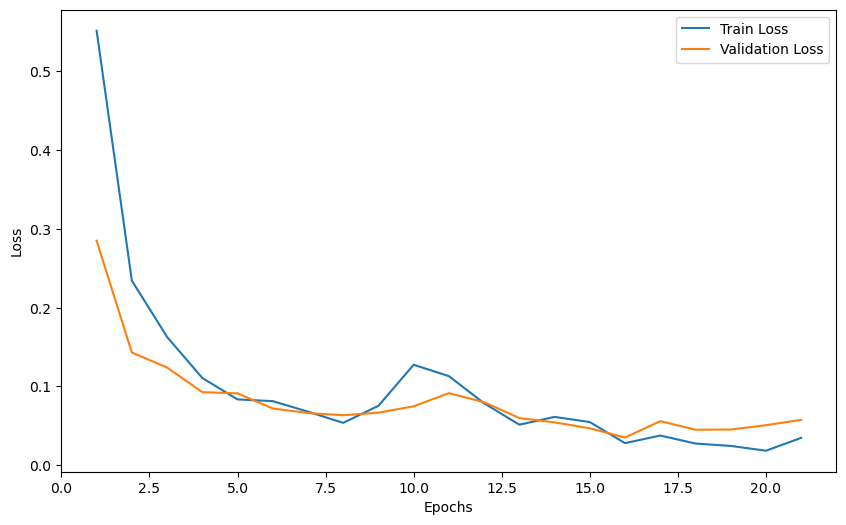

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize= (10,6))
plt.plot(range(1, len(train_loss)+1), train_loss, label= "Train Loss")
plt.plot(range(1, len(val_loss)+1), val_loss, label= "Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show();

## 3. Model Testing

In [7]:
torch.manual_seed(0)

model= CNNnetwork()
state_dict= torch.load("Audio_CNN.pth", weights_only=True)
model.load_state_dict(state_dict=state_dict)
model.eval()

real_indices= [i for i, label in enumerate(audio_dataset.labels) if label == 0]
fake_indices= [i for i, label in enumerate(audio_dataset.labels) if label == 1]
real_sample= random.sample(real_indices, 100)
fake_sample= random.sample(fake_indices, 150)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
test_dataset= Subset(audio_dataset, subset_indices)
test_loader= DataLoader(test_dataset, batch_size=128, shuffle=True)

acc, prec, rec, f1= evaluate_classification_model(model, test_loader, device)

Accuracy: 0.9720
Precision: 0.9726
Recall: 0.9720
F1-score: 0.9719


In [9]:
FAKE_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\validation\fake"
REAL_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\validation\real"

valid_audio_dataset= AudioDataset(
    FAKE_AUDIO_PATH,
    REAL_AUDIO_PATH,
    mel_spectogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    CORRUPTED_PATHS,
    AudioHandler
)

real_indices= [i for i, label in enumerate(valid_audio_dataset.labels) if label==0]
fake_indices= [i for i, label in enumerate(valid_audio_dataset.labels) if label==1]
real_sample= random.sample(real_indices, 1000)
fake_sample= random.sample(fake_indices, 1000)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
valid_dataset= Subset(valid_audio_dataset, subset_indices)
valid_loader= DataLoader(valid_dataset, batch_size=128, shuffle=True)

acc, prec, rec, f1= evaluate_classification_model(model, valid_loader, device)

Accuracy: 0.9755
Precision: 0.9759
Recall: 0.9755
F1-score: 0.9755
